In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import xgboost as xgb

## 1. Read data and basic analysis

In [2]:
df = pd.read_csv("Dataset_A_loan.csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (45000, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int

Drop duplicate, Check missing value, and print sample data

In [3]:
# Drop Duplicate
df.drop_duplicates(inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Display sample data
print("\nSample Data:")
df.head(10)


Missing Values:
person_income    2250
dtype: int64

Sample Data:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,NaN,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


there are some missing values, we will deal with them in the next step

In [4]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")


Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']
Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


## 2. Preprocess & EDA

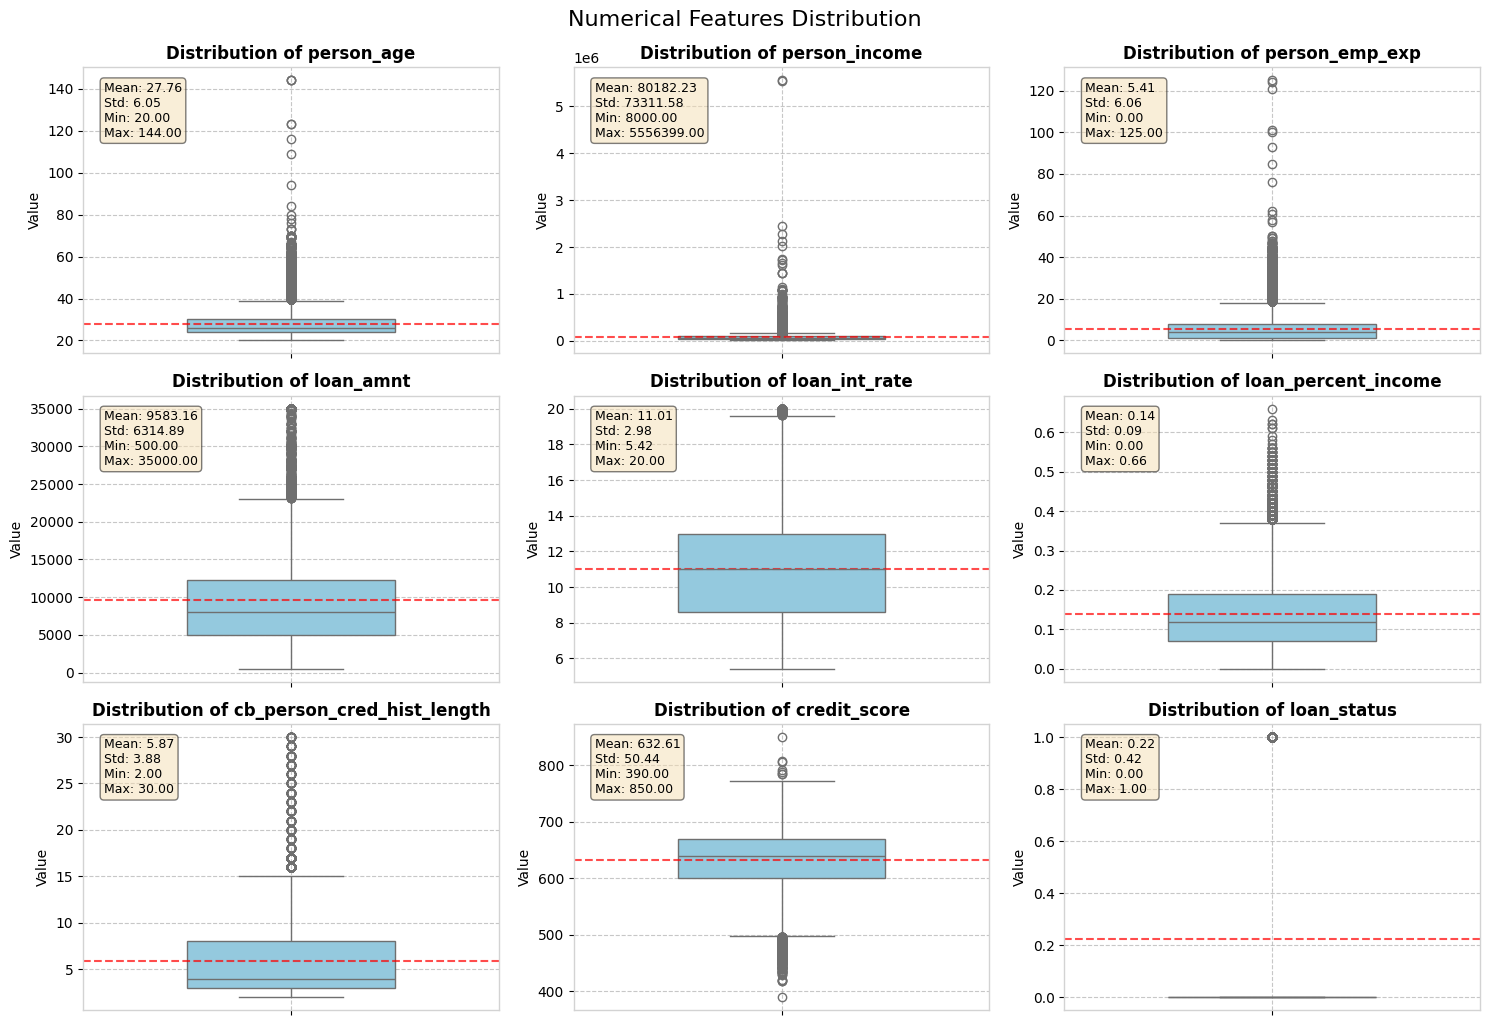

In [5]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(3, 3, i)
    
    # Plot boxplot with improved styling
    sns.boxplot(y=df[col], ax=ax, color='skyblue', width=0.5)
    
    # Plot mean line
    plt.axhline(df[col].mean(), color='red', linestyle='--', alpha=0.7, 
                linewidth=1.5, label=f'Mean: {df[col].mean():.2f}')
    
    # Formatting titles and labels
    plt.title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    plt.ylabel('Value', fontsize=10)
    
    # Add statistics in the corner
    textstr = f'Mean: {df[col].mean():.2f}\nStd: {df[col].std():.2f}\nMin: {df[col].min():.2f}\nMax: {df[col].max():.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', bbox=props)
    
    # Enhanced grid and spines
    ax.grid(True, linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)

plt.tight_layout()
plt.suptitle('Numerical Features Distribution', fontsize=16, y=1.02)
plt.show()

there are several column with some outlier values

we are going to cap outliers at 3 standard deviations from the mean

In [6]:
def cap_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

# Apply outlier capping to numeric columns with extreme values
for col in ['person_income', 'person_age', 'loan_amnt', 'person_emp_exp']:
    df = cap_outliers(df, col)

In [7]:
# KNN imputation for missing values (particularly for 'person_income')
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

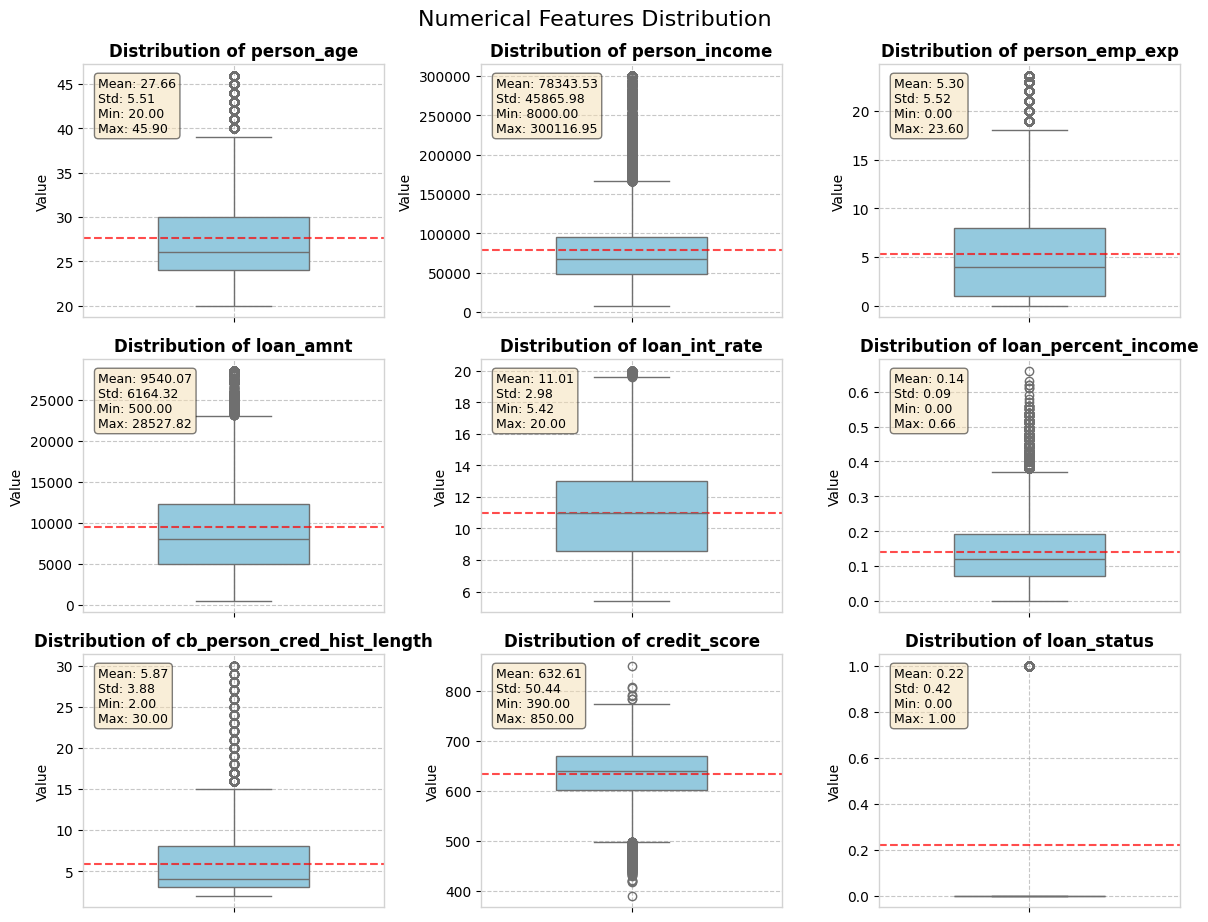

In [ ]:
plt.figure(figsize=(12, 9))

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(3, 3, i)
    
    sns.boxplot(y=df[col], ax=ax, color='skyblue', width=0.5)
    
    plt.axhline(df[col].mean(), color='red', linestyle='--', alpha=0.7, 
                linewidth=1.5, label=f'Mean: {df[col].mean():.2f}')
    
    plt.title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    plt.ylabel('Value', fontsize=10)
    
    textstr = f'Mean: {df[col].mean():.2f}\nStd: {df[col].std():.2f}\nMin: {df[col].min():.2f}\nMax: {df[col].max():.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', bbox=props)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)

plt.tight_layout()
plt.suptitle('Numerical Features Distribution', fontsize=16, y=1.02)
plt.show()

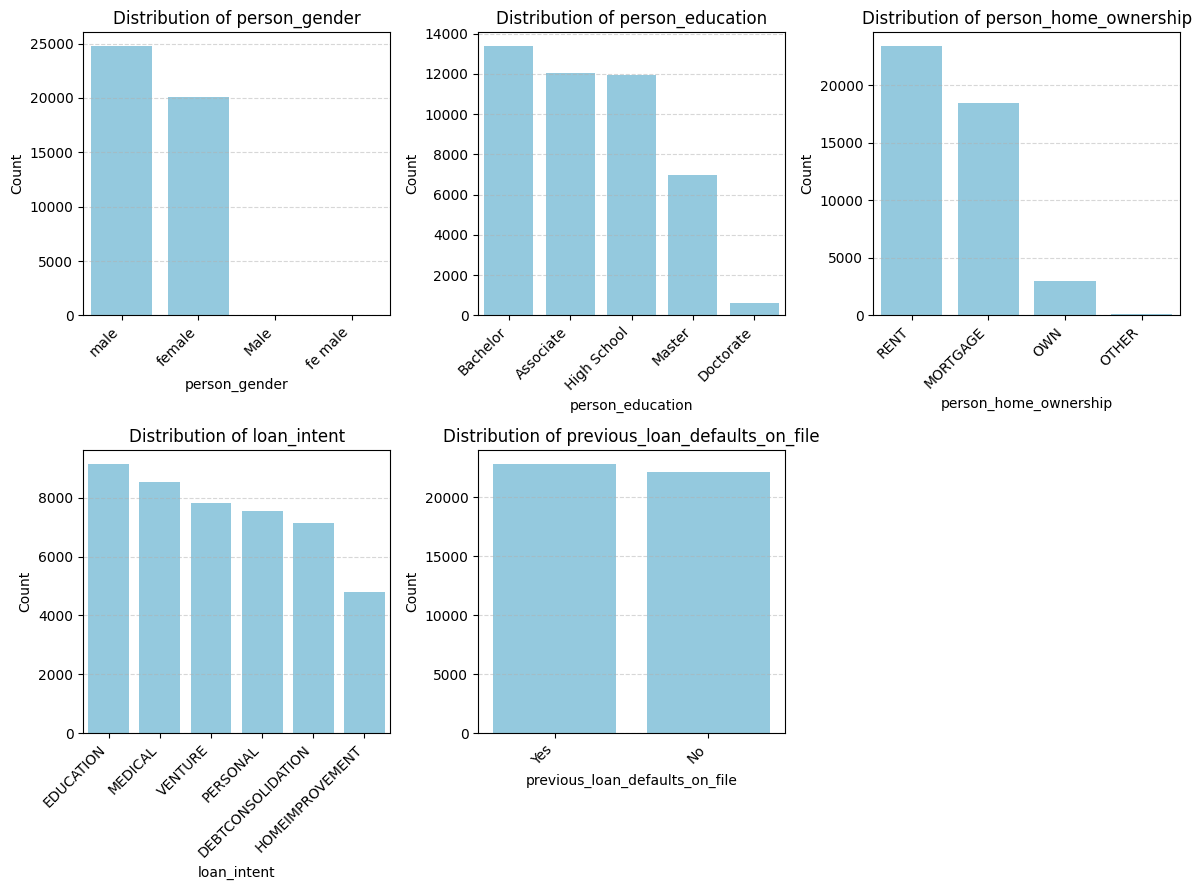

In [ ]:
plt.figure(figsize=(12, 9))
n_rows = 2
n_cols = 3

for i, col in enumerate(cat_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    # Count values and create a simple bar plot
    value_counts = df[col].value_counts().sort_values(ascending=False)
    sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue', ax=ax)
    
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    
    # Rotate labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Simple grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

From the plots, I notice some inconsistencies in person_gender (both 'male'/'Male' and 'female'/'fe male')

**Fix person_gender inconsistencies**


In [10]:
df['person_gender'] = df['person_gender'].str.lower()
df['person_gender'] = df['person_gender'].replace('fe male', 'female')

**Education level as ordinal feature**

In [11]:
education_order = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
df['education_level'] = df['person_education'].map(education_order)

df.drop(columns=['person_education'], inplace=True)

## 3. Preparing features and target

use one-hot encoding for categorical variables

In [12]:
X = pd.get_dummies(df.drop('loan_status', axis=1))
y = df['loan_status']

Test train split with 80:20 proportion

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Training

**train random forest and xgboost**

In [14]:
# Train Random Forest model
print("Training Random Forest model...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time
print(f"Random Forest training time: {rf_training_time:.2f} seconds")

# Train XGBoost model
print("Training XGBoost model...")
start_time = time.time()
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time
print(f"XGBoost training time: {xgb_training_time:.2f} seconds")

Training Random Forest model...
Random Forest training time: 0.28 seconds
Training XGBoost model...
XGBoost training time: 0.20 seconds


**model predictions**

In [15]:
# Generate predictions
def get_predictions(model, X_test):
    # Test set predictions
    start_time = time.time()
    y_test_pred = model.predict(X_test)
    test_pred_time = time.time() - start_time
    
    return {
        'y_test_pred': y_test_pred,
        'test_pred_time': test_pred_time
    }

# Get predictions for both models
rf_preds = get_predictions(rf_model, X_test)
xgb_preds = get_predictions(xgb_model, X_test)

**calculate metrics**

In [16]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Calculate metrics for Random Forest
rf_test_metrics = calculate_metrics(y_test, rf_preds['y_test_pred'])

# Calculate metrics for XGBoost
xgb_test_metrics = calculate_metrics(y_test, xgb_preds['y_test_pred'])


In [17]:
def display_metrics(test_metrics, model_name, pred_time):
    print(f"\n{model_name} Performance:")
    print(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
          f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}, AUC: {test_metrics['auc']:.4f}")
    print(f"Prediction Time: {pred_time:.4f}s")

# Display metrics for both models
display_metrics(rf_test_metrics, "Random Forest", rf_preds['test_pred_time'])
display_metrics(xgb_test_metrics, "XGBoost", xgb_preds['test_pred_time'])



Random Forest Performance:
Test - Accuracy: 0.9279, Precision: 0.8918, Recall: 0.7706, F1: 0.8268, AUC: 0.8719
Prediction Time: 0.0301s

XGBoost Performance:
Test - Accuracy: 0.9317, Precision: 0.8814, Recall: 0.8020, F1: 0.8398, AUC: 0.8855
Prediction Time: 0.0070s


**create confusion matrix**

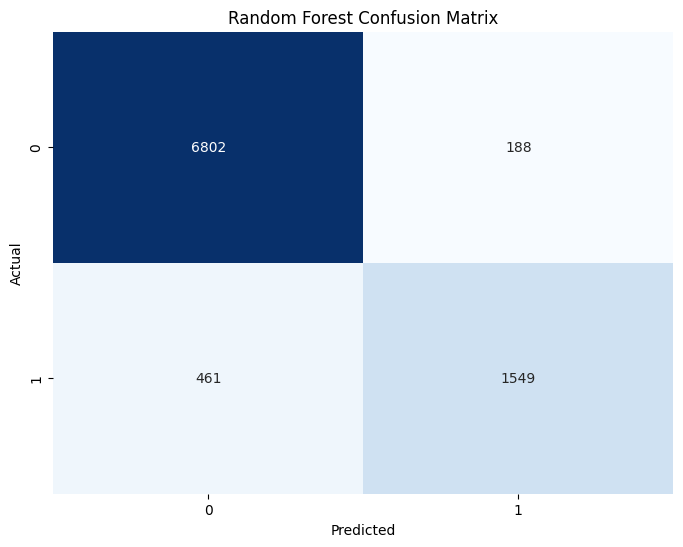

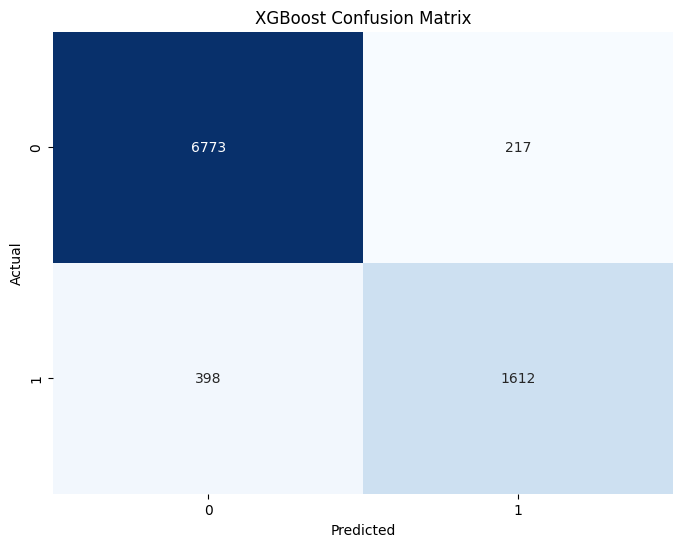

In [18]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, rf_preds['y_test_pred'], "Random Forest")
plot_confusion_matrix(y_test, xgb_preds['y_test_pred'], "XGBoost")

**plot ROC curves**

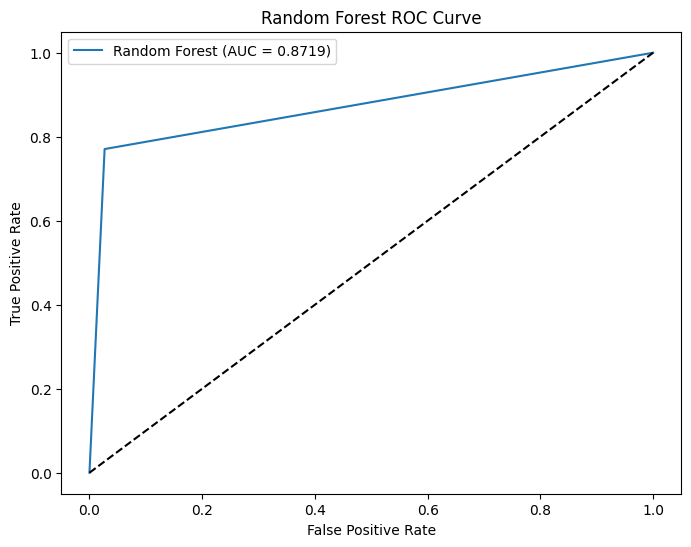

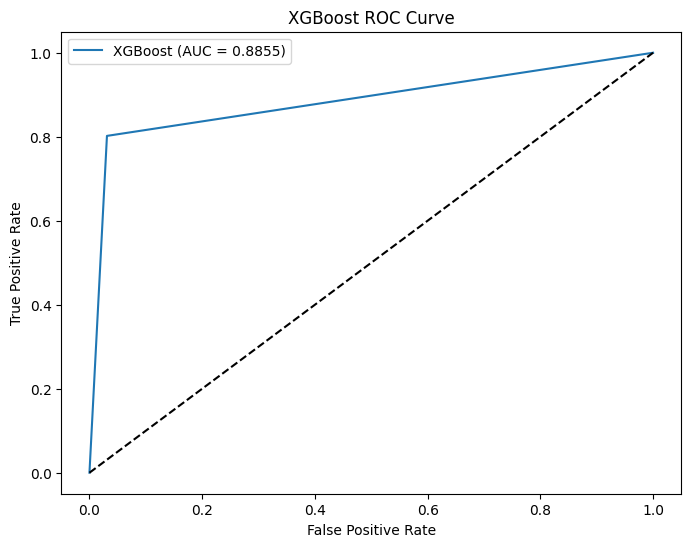

In [19]:
def plot_roc_curve(y_true, y_pred, model_name, auc):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

# Plot ROC curves
plot_roc_curve(y_test, rf_preds['y_test_pred'], "Random Forest", rf_test_metrics['auc'])
plot_roc_curve(y_test, xgb_preds['y_test_pred'], "XGBoost", xgb_test_metrics['auc'])

**feature importance**

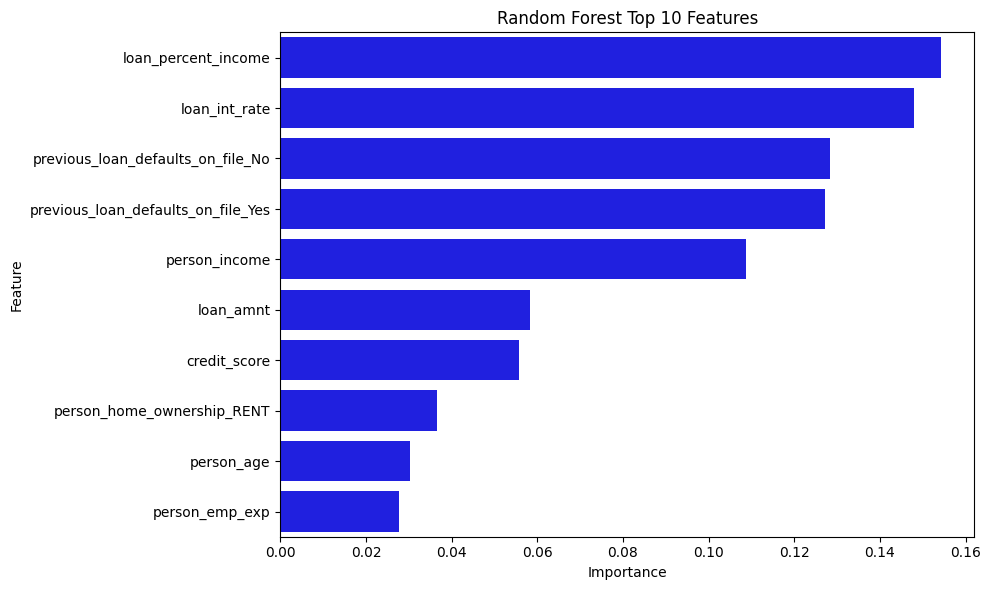

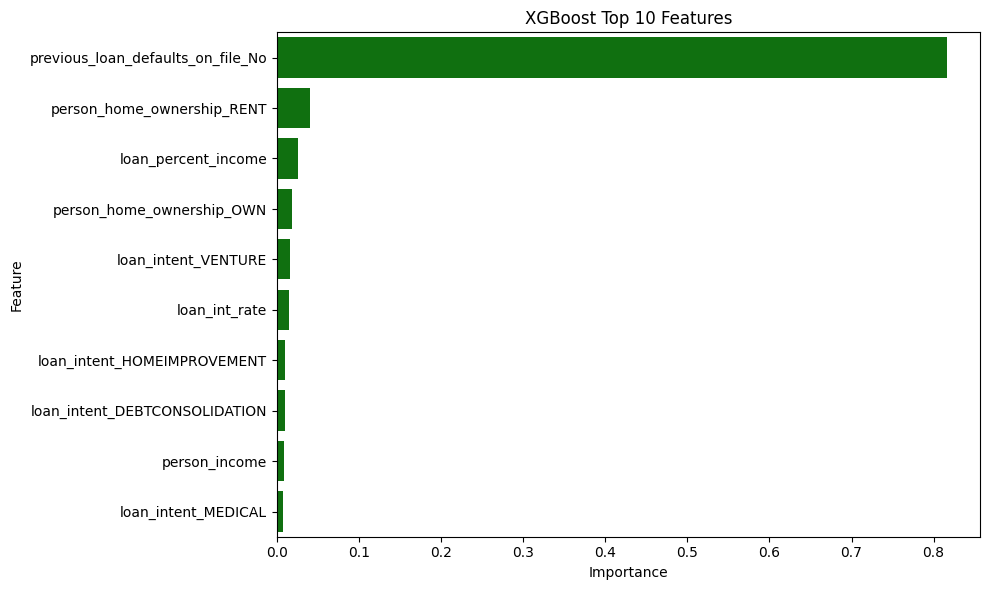

In [20]:
def plot_feature_importance(model, feature_names, model_name):
    # Extract feature importance
    if hasattr(model, 'feature_importances_'):
        # Create DataFrame for feature importance
        importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        # Plot top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance.head(10), 
                    color='blue' if model_name == 'Random Forest' else 'green')
        plt.title(f'{model_name} Top 10 Features')
        plt.tight_layout()
        plt.show()
        
        return importance
    else:
        print(f"{model_name} doesn't have feature_importances_ attribute")
        return None

# Plot for Random Forest
rf_importance = plot_feature_importance(rf_model, X_train.columns, 'Random Forest')

# Plot for XGBoost
xgb_importance = plot_feature_importance(xgb_model, X_train.columns, 'XGBoost')

**classification reports**

In [21]:
def print_classification_report(y_true, y_pred, model_name):
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

# Print classification reports
print_classification_report(y_test, rf_preds['y_test_pred'], "Random Forest")
print_classification_report(y_test, xgb_preds['y_test_pred'], "XGBoost")


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      6990
         1.0       0.89      0.77      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      6990
         1.0       0.88      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



### Model comparison


Model Comparison:
      Metric  Random Forest   XGBoost
0   Accuracy       0.927889  0.931667
1  Precision       0.891767  0.881356
2     Recall       0.770647  0.801990
3   F1 Score       0.826795  0.839802
4        AUC       0.871876  0.885473


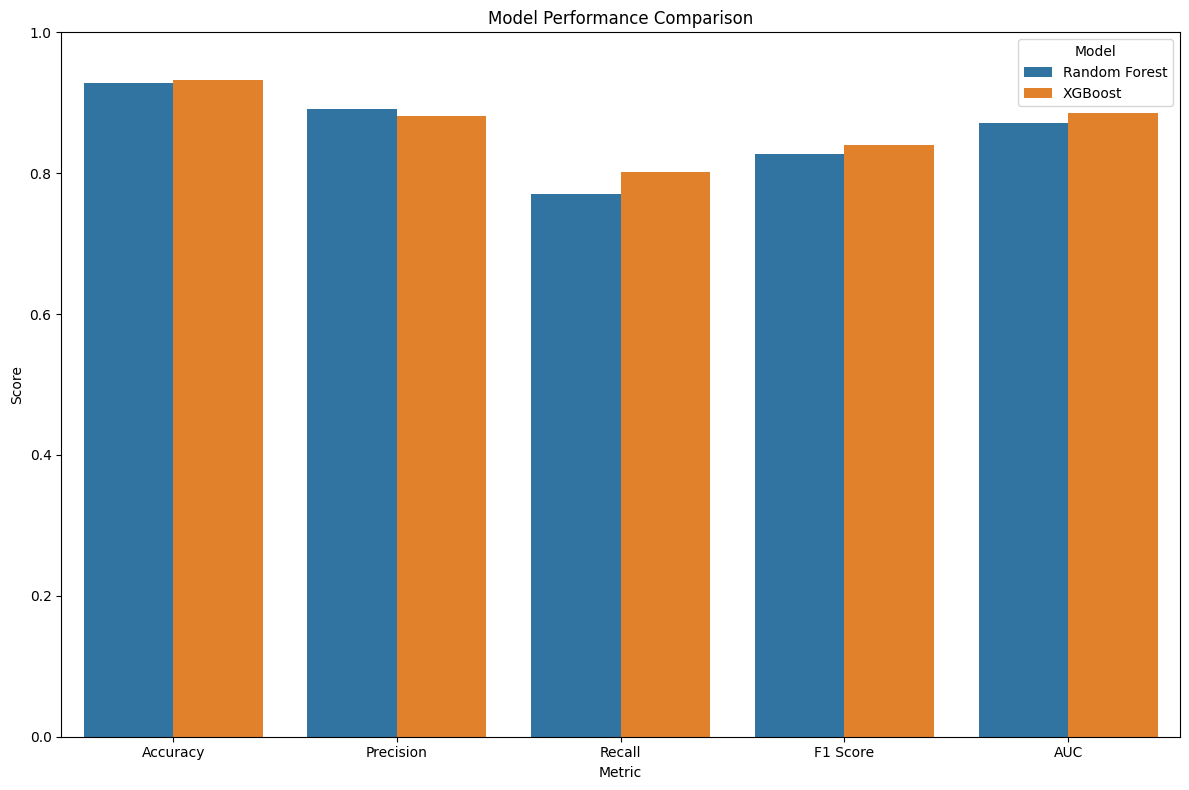

In [22]:
# Create comparison DataFrame
models_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Random Forest': [rf_test_metrics['accuracy'], rf_test_metrics['precision'],
                     rf_test_metrics['recall'], rf_test_metrics['f1'], rf_test_metrics['auc']],
    'XGBoost': [xgb_test_metrics['accuracy'], xgb_test_metrics['precision'],
               xgb_test_metrics['recall'], xgb_test_metrics['f1'], xgb_test_metrics['auc']]
})

# Display comparison table
print("\nModel Comparison:")
print(models_comparison)

# Create bar chart for comparison
models_comparison_melted = pd.melt(models_comparison, id_vars=['Metric'], 
                                  var_name='Model', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=models_comparison_melted)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

because xgboost is the better model here, we choose xgboost as our main model, so we apply simple fine tuning

In [23]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    # Initialize the model with the suggested parameters
    model = XGBClassifier(random_state=42, n_jobs=-1, **param)
    
    # Perform cross-validation and return the mean ROC AUC score
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1).mean()
    return score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

# Train the final model with the best parameters
best_xgb_model = XGBClassifier(random_state=42, n_jobs=-1, **best_params)
best_xgb_model.fit(X_train, y_train)

C:\Users\Ghazi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-19 21:26:52,821] A new study created in memory with name: no-name-557625e2-9883-416b-b9d3-877be0339554
[I 2025-04-19 21:26:54,903] Trial 0 finished with value: 0.9723800370896193 and parameters: {'n_estimators': 218, 'max_depth': 9, 'learning_rate': 0.26532580258015087, 'subsample': 0.651403102669299, 'colsample_bytree': 0.6645261655633204, 'gamma': 0.6159951630221588, 'min_child_weight': 4}. Best is trial 0 with value: 0.9723800370896193.
[I 2025-04-19 21:26:56,375] Trial 1 finished with value: 0.9737930060828379 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.026664743814460427, 'subsample': 0.7417647471862923,

Best Parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.05793433490292858, 'subsample': 0.9003752569438986, 'colsample_bytree': 0.8100945077922569, 'gamma': 0.12543636073563358, 'min_child_weight': 2}
Best ROC AUC Score: 0.9765642956661095


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8100945077922569, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.12543636073563358, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05793433490292858,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=235, n_jobs=-1,
              num_parallel_tree=None, ...)

In [24]:
# Print classification report for the best XGBoost model
print_classification_report(y_test, best_xgb_model.predict(X_test), "Best XGBoost Model")


Best XGBoost Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      6990
         1.0       0.89      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



### Save best model to pickle

In [25]:
import pickle

# Save the XGBoost model to a pickle file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

print("XGBoost model saved as 'xgboost_model.pkl'")

XGBoost model saved as 'xgboost_model.pkl'


### Three random case for streamlit

In [26]:
# Get 3 random rows from the dataframe
random_samples = X_test.sample(n=3)

# Print the 3 random rows
random_samples

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,education_level,person_gender_female,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
43451,32.0,144025.0,13.0,24806.0,11.75,0.17,5.0,685.0,5,False,...,False,False,False,True,False,False,False,False,True,False
24584,33.0,90942.0,8.0,6000.0,7.90,0.07,8.0,651.0,1,False,...,False,False,False,False,False,False,True,False,False,True
31733,36.0,73169.0,14.0,15000.0,13.57,0.21,12.0,744.0,5,True,...,False,True,False,False,True,False,False,False,True,False


In [27]:
# Get the corresponding y_test values for the random samples
random_samples_y_test = y_test.loc[random_samples.index].reset_index(drop=True)

# Display the y_test values
random_samples_y_test

0    1.0
1    0.0
2    0.0
Name: loan_status, dtype: float64

In [28]:
prediction = best_xgb_model.predict(random_samples)

prediction

array([0, 0, 0])